# Automatizce ve fyzice: Bayesovská optimalizace

Petr Čermák  
2023-11-24

## Připojte se

{{< qrcode https://cermak.science/teaching/automation/lectures/07-bo/presentation.html >}}

[cermak.science/teaching/automation/lectures/07-bo/presentation.html](https://cermak.science/teaching/automation/lectures/07-bo/presentation.html)

# Statistika v kostce

## Obecné pojmy - pravděpodobnostní model

Likehood funkce

-   funkce věrohodnosti
-   $\mathcal{L}(\theta; D)$
-   vyjadřuje pravděpodobnost, že by daná sada parametrů $\theta$
    generovala pozorovaná data $D$.

Náhodný proces

-   výsledkem je funkce

Modely

-   parametrické (konečný/malý počet parametrů)
-   non-parametric (nekonečně/hodně) parametrů

non-parametric: Savitzky–Golay filter (lokální aproximace polynomy)

## Obecné pojmy

Metoda maximální věrohodnosti

-   MLE (Maximum likelihood estimation)
-   hledám parametry modelu, které vygenerují naměřená data s největší
    pravděpodobností

$$ \hat{\theta}_{\text{MLE}} = \arg \max_{\theta} \mathcal{L}(\theta; D) $$

Maximální aposteriorní odhad

-   MAP (Maximum a Posteriori Estimation)
-   Parametry nejsou náhodné, známe jejich distribuci
-   Kombinace likehood funkce a apriorní informace o parametrech

$$
P(\theta | D) = \frac{P(D | \theta) \cdot P(\theta)}{P(D)}
$$

$$
\hat{\theta}_{\text{MAP}} = \arg \max_{\theta} P(\theta | D)
$$

# Gaussovské procesy

## Gaussovský proces

-   model náhodného procesu
-   neparametrický
-   hodnoty jsou náhodné proměné, vzájemně korelované
-   popisuje ho střední hodnota a kovarianční funkce (určuje hladkost)
-   pro dva blízké body $x_j$ a $x_i$ platí, že jejich $f(x_n$)\$ jsou
    také blízké
-   za pomoci tréninkového datasetu umí predikovat další hodnoty

## Příklad jádra (kovarianční fce): RBF

RBF (Radial Basis Function, jádro exponentu kvadratického) $$
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma^2 \exp\left(-\frac{\|\mathbf{x}_i - \mathbf{x}_j\|^2}{2l^2}\right)
$$

kde $l$ ovlivňuje jak rychle korelace klesá a $\sigma$ určuje škálování
jádra.

In [1]:
import numpy as np

def kernel(X1, X2, l=1.0, sigma=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1,2: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma**2 * np.exp(-0.5 / l**2 * sqdist)

## Prior (nevíme nic)

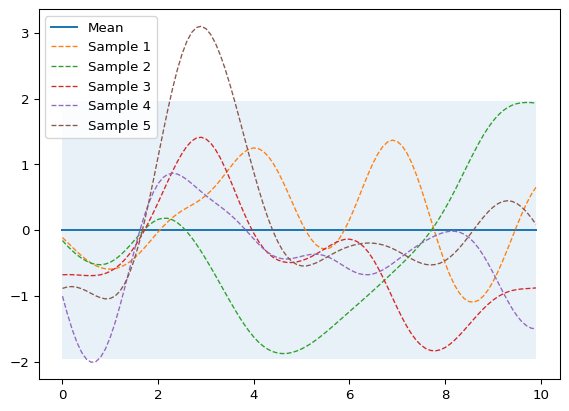

In [2]:
from helper import plot_gp

# Vygeneruji body (konečný počet)
X = np.arange(0, 10, 0.1).reshape(-1, 1) #počet sloupců dopočítá

mu = np.zeros(X.shape)   # střední hodnota
cov = kernel(X, X)       # spočtu kovarianci (nenormovaná korelace)

# Vygeneruji 5 funkcí jako výsledek náhodného gaussovského procesu
samples = np.random.multivariate_normal(mu.ravel(), cov, 5)

# Vykreslí střední hodnotu, oblast nejistoty a funkce 
plot_gp(mu, cov, X, samples=samples)

## Posterior

In [3]:
from numpy.linalg import inv

def posterior(X, X_train, Y_train, l=1.0, sigma=1.0, sigma_y=1e-8):
    """
    Spočítá novou střední hodnotu a kovarianci při znalosti train dat
    
    Args:
        X: osa x
        X_train, Y_train: známá data (m x 1)
        l, sigma: Parametry jádra
        sigma_y: šum
    
    Returns:
        Posterior střední hodnota (n x d) a kovariance (n x n).
    """
    K = kernel(X_train, X_train, l, sigma) + sigma_y**2 * np.eye(len(X_train))  # jádro s šumem
    K_s = kernel(X_train, X, l, sigma)
    K_ss = kernel(X, X, l, sigma) + 1e-8 * np.eye(len(X))
    
    # Equation (7)
    mu_s = K_s.T.dot(inv(K)).dot(Y_train)
    # Equation (8)
    cov_s = K_ss - K_s.T.dot(inv(K)).dot(K_s)
    return mu_s, cov_s

$$
 \mathbf{\mu_*} = \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{y}
$$ $$
 \mathbf{\Sigma_*} = \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{K}_* 
$$

Odvození
[zde](https://krasserm.github.io/2018/03/19/gaussian-processes/).

## Zadáme data (bez šumu)

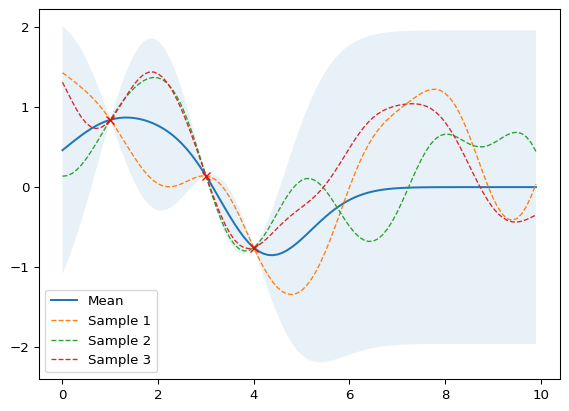

In [4]:
# Zadáme data
X_train = np.array([1, 3, 4]).reshape(-1, 1)
Y_train = np.sin(X_train)
# Spočteme novou (posterior) střední hodnotu a kovarianci
mu_s, cov_s = posterior(X, X_train, Y_train)
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

To není dokonalé - ta data nejsou z principu přesná.

## Zadáme data (se šumem)

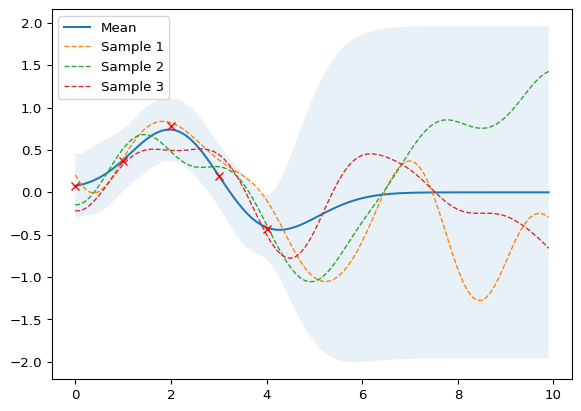

In [5]:
# Zašuměná data
noise = 0.2
X_train = np.arange(0, 5, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)
mu_s, cov_s = posterior(X, X_train, Y_train, sigma_y=noise)
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

Fajn, jak nastavit ty parametry?

## Vliv parametrů

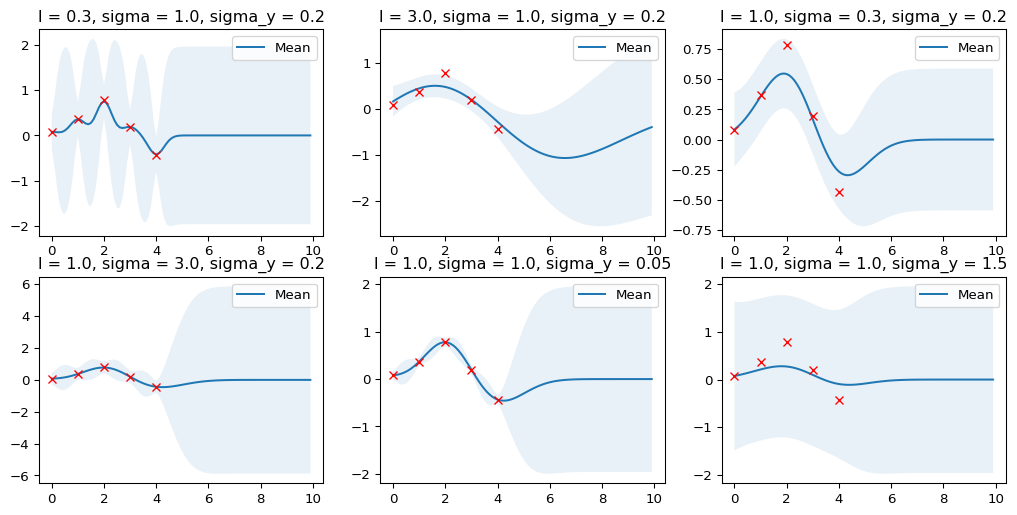

In [6]:
import matplotlib.pyplot as plt

params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(13, 2.5))

for i, (l, sigma, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior(X, X_train, Y_train, l=l, 
                            sigma=sigma, 
                            sigma_y=sigma_y)
    plt.subplot(2, 3, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma = {sigma}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

## Optimální parametry

Lze nalézt optimální parametry

$$
\log p(\mathbf{y} \lvert \mathbf{X}) = 
\log \mathcal{N}(\mathbf{y} \lvert \mathbf{0},\mathbf{K}_y) =
-\frac{1}{2} \mathbf{y}^T \mathbf{K}_y^{-1} \mathbf{y} 
-\frac{1}{2} \log \begin{vmatrix}\mathbf{K}_y\end{vmatrix} 
-\frac{N}{2} \log(2\pi)
$$

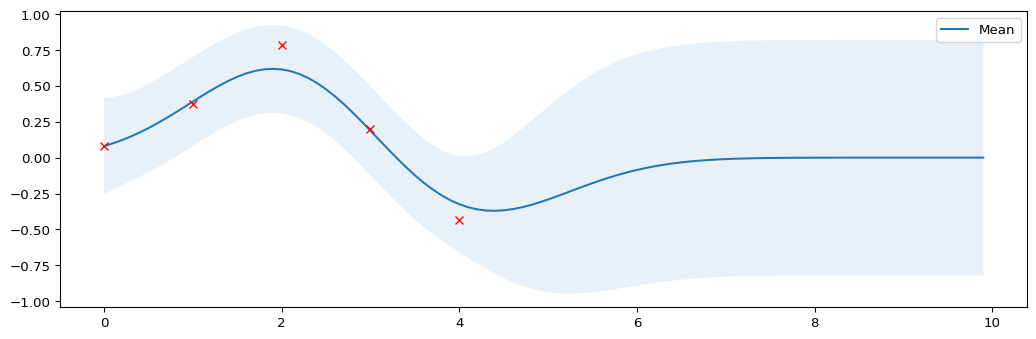

In [7]:
from numpy.linalg import cholesky, det
from scipy.linalg import solve_triangular
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise, naive=True):
    """
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and given
    noise level.

    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        naive: if True use a naive implementation of Eq. (11), if
               False use a numerically more stable implementation.

    Returns:
        Minimization objective.
    """
    
    Y_train = Y_train.ravel()
    
    def nll_naive(theta):
        # Naive implementation of Eq. (11). Works well for the examples 
        # in this article but is numerically less stable compared to 
        # the implementation in nll_stable below.
        K = kernel(X_train, X_train, l=theta[0], sigma=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)
        
    def nll_stable(theta):
        # Numerically more stable implementation of Eq. (11) as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.
        
        K = kernel(X_train, X_train, l=theta[0], sigma=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        L = cholesky(K)
        
        S1 = solve_triangular(L, Y_train, lower=True)
        S2 = solve_triangular(L.T, S1, lower=False)
        
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.dot(S2) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    if naive:
        return nll_naive
    else:
        return nll_stable

# Minimize the negative log-likelihood w.r.t. parameters l and sigma_f.
# We should actually run the minimization several times with different
# initializations to avoid local minima but this is skipped here for
# simplicity.
res = minimize(nll_fn(X_train, Y_train, noise), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
l_opt, sigma_f_opt = res.x

# Compute posterior mean and covariance with optimized kernel parameters and plot the results
mu_s, cov_s = posterior(X, X_train, Y_train, l=l_opt, sigma=sigma_f_opt, sigma_y=noise)
plt.figure(figsize=(13, 4))
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

## Více rozměrů

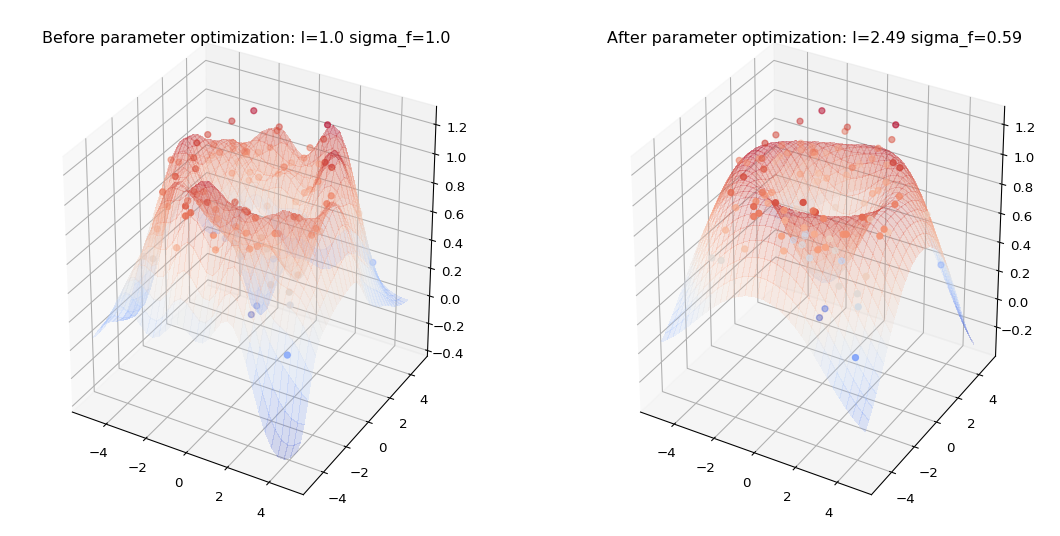

In [8]:
from helper import plot_gp_2D

noise_2D = 0.1

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = np.random.uniform(-4, 4, (100, 2))
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis=1)) + \
             noise_2D * np.random.randn(len(X_2D_train))

plt.figure(figsize=(14,7))

mu_s, _ = posterior(X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, 
           f'Before parameter optimization: l={1.00} sigma_f={1.00}', 1)

res = minimize(nll_fn(X_2D_train, Y_2D_train, noise_2D), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

mu_s, _ = posterior(X_2D, X_2D_train, Y_2D_train, *res.x, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train,
           f'After parameter optimization: l={res.x[0]:.2f} sigma_f={res.x[1]:.2f}', 2)

## Jsou na to knihovny

Scikit-learn

-   `GaussianProcessRegressor` vytváří posterior data (“fituje hodnoty”)
-   Připravená jádra

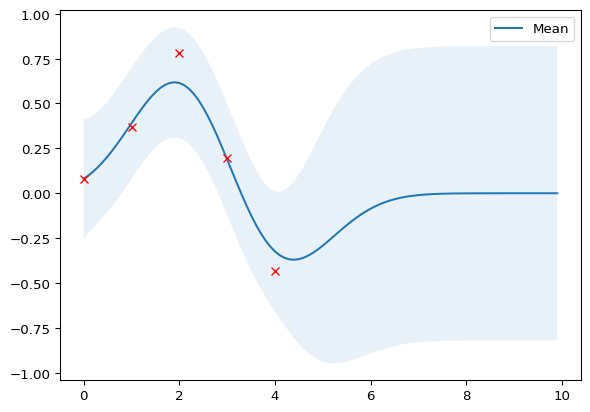

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2)

# Použiju stará data
gpr.fit(X_train, Y_train)

# Výpočet posterior parametrů
mu_s, cov_s = gpr.predict(X, return_cov=True)

# Optimalizované parametry Gausse
l = gpr.kernel_.k2.get_params()['length_scale']
sigma = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])

plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

## Knihovna GPy

-   Vyvíjeno Sheffield machine learning group.
-   Hezčí grafy

In [10]:
import GPy

rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X_train, Y_train, rbf)

# Zafixovat šum
gpr.Gaussian_noise.variance = noise**2
gpr.Gaussian_noise.variance.fix()

# Optimalizovat parametry
gpr.optimize()

# Výsledky
l = gpr.rbf.lengthscale.values[0]
sigma = np.sqrt(gpr.rbf.variance.values[0])

# Zobraz parametry a graf
display(gpr)

Model : GP regression 
 Objective : 2.1951158981657186 
 Number of Parameters : 3 
 Number of Optimization Parameters : 2 
 Updates : True

## Knihovna GPy

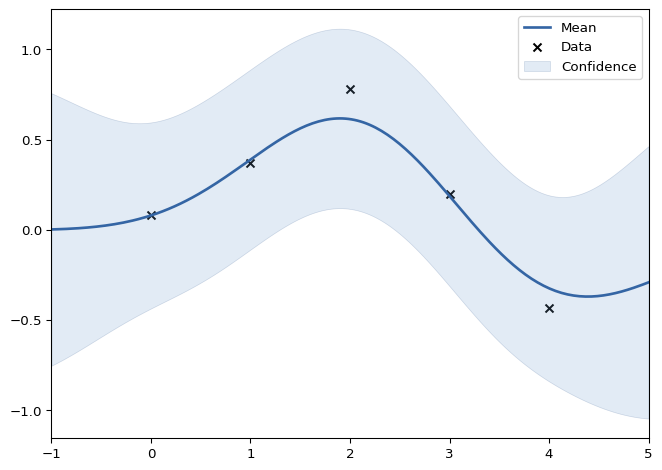

In [11]:
gpr.plot()
plt.show()

# Bayesovská optimalizace

## Co optimalizovat?

Funkce typu “black-box”

-   neznáme jaká funkce to je
-   nevíme její derivace
-   měření v bodě –\> zašuměná odpověď

Co když měření trvá dlouho?

-   najít minimum za pomocí nejmenšího počtu měření

–\> Bayesovská optimalizace! Potřebujeme:

-   **Náhradní (Surrogate) model** (GP!!)
-   **Akviziční funkce** - vymyslí na základě modelu, kde dále měřit

## Akviziční funkce

-   hledá kompromis mezi
    -   *průzkumem* (exploration) - měřit tam, kde nic nevíme
    -   *vytěžováním* (exploitation) - měřit tom, kde se odhaduje
        minimum/maximum
-   používané funkce:
    -   “maximum probability of improvement” (MPI)
    -   “upper confidence bound” (UCB)
    -   **“expected improvement” (EI)**

$$
\mathrm{EI}(\mathbf{x}) = \mathbb{E}\max(f(\mathbf{x}) - \mathbf{y}^+, 0)
$$

kde $\mathbf{y}$ je zatím nejlepší hodnota, $f(\mathbf{x})$ je náš gp
model a $\mathbb{E}$ značí očekávání.

## Scikit-optimize

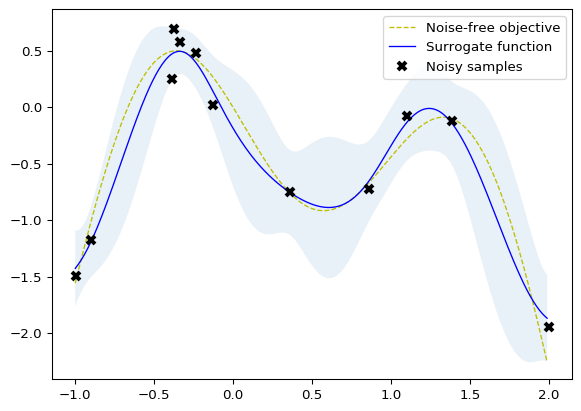

In [12]:
import numpy as np
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern
from helper import plot_approximation, plot_acquisition

bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)
# pro plotování:
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)
Y = f(X,0)

# Definice jádra
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

r = gp_minimize(lambda x: -f(np.array(x))[0], 
                bounds.tolist(),
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=10,         # number of iterations
                n_random_starts=0,  # initial samples are provided
                x0=X_init.tolist(), # initial samples
                y0=-Y_init.ravel())

# Fit GP model to samples for plotting results
gpr.fit(r.x_iters, -r.func_vals)

# Plot the fitted model and the noisy samples
plot_approximation(gpr, X, Y, r.x_iters, -r.func_vals, show_legend=True)

## GPyOpt

In [13]:
import GPy
import GPyOpt

from GPyOpt.methods import BayesianOptimization

kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
bds = [{'name': 'X', 'type': 'continuous', 'domain': bounds.ravel()}]

optimizer = BayesianOptimization(f=f, 
                                 domain=bds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 X=X_init,
                                 Y=-Y_init,
                                 noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True)

optimizer.run_optimization(max_iter=10)
optimizer.plot_acquisition()